In [263]:
import faraday_rotation as fr
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from  matplotlib import ticker
import numpy as np

In [235]:
%qtconsole

In [3]:
# target settings:
target_settings = {
    'x_s': 0,  # start position in x direction, in micron
    'x_e': 7.2,  # end position in x direction, in micron
    'y_s': -13.5,  # start in y direction, in micron
    'y_e': 13.5,  # end in y direction, in micron
    'trans': 0.72 #target transmission
}

In [4]:
# target = fr.Target(**target_settings)

In [5]:
# simulation settings:
simulation_settings = {
    'm': 1801,  # Nx: grid number in x direction
    'n': 6040,  # Ny: grid number if y direction, MUST be an even number
    'energy': 6.457  # Photon energy in keV of processed simulation file.
}

simulation = fr.Simulation(fr.Target(**target_settings), **simulation_settings)

In [6]:
# optical setup:

#Transmission of all channelcuts including spectral bandwidth.
trans_channel = 0.43*0.6/0.8 

config_settings = {
    'an_position': -10, # analyzer position (mrad)
    'impurity': 1e-5,  # polarization impurity (1 = 100%)
    'an_extinction': 2e-7,  # analyzer extinction (1 = 100%)
    'det_obs_energy': 6.457, # observation energy in keV
    'det_trans_channel': trans_channel, # as above
    'det_pixel_size': 13,  # pixel size in micrometer
    'det_beam_width': 320,  # beam_width in micrometer
    'n_0': 1e12,  # initial number of photons
    'm': 30,  # magnification
    'trans_telescope': 1  # Transmission of CRLs due to beam size
        # mismatch (asymmetry).
}

config = fr.Configuration(**config_settings)

In [7]:
# load simulation data:
path_to_file = "rotation_data/Rotation_16.dat"
#simulation.load_data(path=path_to_file)

In [8]:
#np.save('sim', simulation.data)

In [9]:

simulation.data = np.load('sim.npy')

In [10]:
experiment = fr.Detection(config, simulation)

In [11]:
experiment.calc_rotation()

In [12]:
experiment.calc_det_shape()

In [13]:
experiment.emulate_intensity()

/home/ordyna35/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [14]:
experiment.cfg.calc_ph_per_px_on_axis()

160000000.0

In [15]:
experiment.calc_beam_profile()

Displaying meany images with a common norm. (One colorbar, comparable; multiply some if the range is to wide)
Look here: https://matplotlib.org/gallery/images_contours_and_fields/multi_image.html 

In [16]:
experiment.ideal_detector = experiment.beam_profile*experiment.intensity_px

In [17]:
exp_with_noise = experiment.add_noise(accumulation=1)

In [18]:
exp_noise_acc = experiment.add_noise(accumulation = 30)

In [19]:
base_noise_acc = experiment.add_noise(accumulation=30, image=experiment.beam_profile)

In [20]:
rot = experiment.reobtain_rotation(exp_noise_acc, base_noise_acc)

Plots:

In [21]:
%matplotlib inline

In [266]:
def plot_rot(cmap, figsize, rotation, intensity_px, re_rot):
    rot_fig, axis = plt.subplots(1, 3, figsize=figsize)
    ax_rot_sim, ax_rot_sim_px, ax_rot_exp = axis

    ax_rot_sim.set_title('Simulated rotation')
    ax_rot_sim_px.set_title('Analyzer intensity profile')
    ax_rot_exp.set_title('Reobtained rotation')

    # Image boundaries, used for correct ticks labeling:
    edges = (experiment.sim.target.x_s, experiment.sim.target.x_e,
             experiment.sim.target.y_s, experiment.sim.target.y_e)
    
    v_min = min([np.min(rotation), np.min(re_rot)])
    v_max = max([np.max(rotation), np.max(re_rot)])
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
    
    ax_rot_sim.imshow(rotation, extent=edges, cmap=cmap, norm=norm)
    ax_rot_sim_px.imshow(intensity_px, extent=edges, cmap=cmap)
    ax_rot_exp.imshow(re_rot, extent=edges, cmap=cmap, norm=norm)
    
    c_bars = [None] * 3
    c_bars[0] = rot_fig.colorbar(axis[0].images[0], ax = axis[0])
    c_bars[1] = rot_fig.colorbar(axis[1].images[0], ax = axis[1], format=ticker.StrMethodFormatter('{x:.2e}'))
    c_bars[2] = rot_fig.colorbar(axis[2].images[0], ax = axis[2])

    c_bars[0].ax.set_title('[mrad]')
    #c_bars[1].ax.set_title('[mrad]')
    c_bars[2].ax.set_title('[mrad]')
    #c_bars[1].ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    
    for ax in axis:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto', prune=None))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto', prune=None))
    #for c_bar in c_bars:
     #   c_bar.ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto', prune=None))
    plt.tight_layout()  



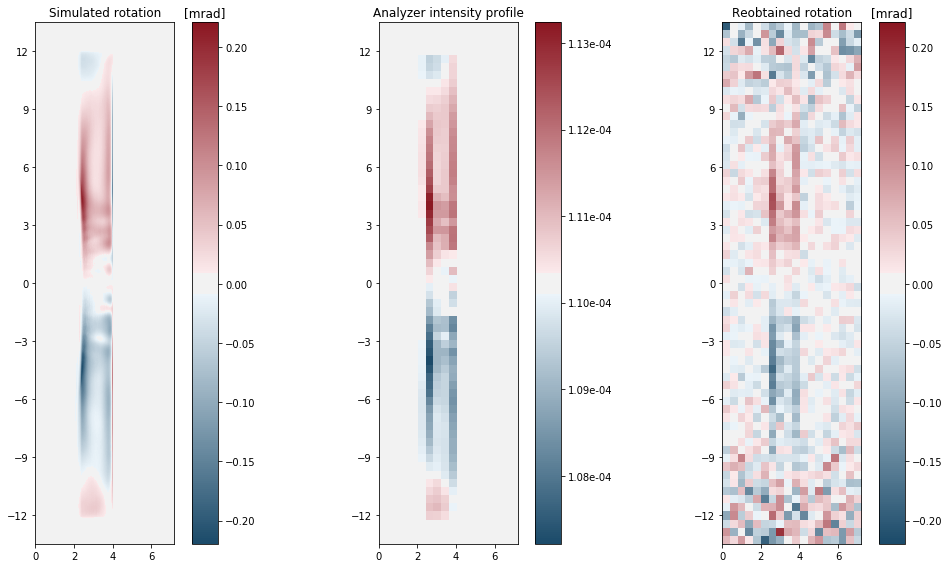

In [267]:
cmap = sns.diverging_palette(240, 10, s=85, l=30, n=256 , center = 'light', as_cmap=True)
plot_rot(cmap, (15,8), experiment.rotation, experiment.intensity_px, rot)

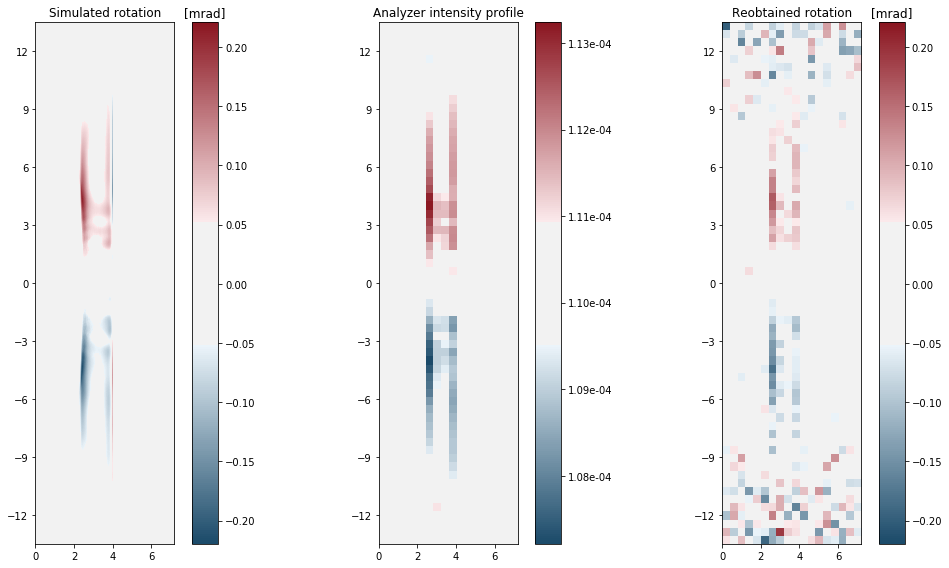

In [269]:
cmap_extr = sns.diverging_palette(240, 10, s=85, l=30, n=256 , sep=60, center = 'light', as_cmap=True)
plot_rot(cmap_extr, (15,8), experiment.rotation, experiment.intensity_px, rot)

In [290]:
def plot_det(cmap, figsize, base_noise_acc, exp_with_noise, exp_noise_acc):
    exp_fig, axis = plt.subplots(1, 3, figsize=figsize)
    ax_ref_acc, ax_ex_noise, ax_ex_acc = axis

    ax_ref_acc.set_title('Reference image, \n accumulated ... times.')
    ax_ex_noise.set_title('Signal with added noise.')
    ax_ex_acc.set_title('Accumulated noisy signal')
    # Image boundaries, used for correct ticks labeling:
    edges = (experiment.sim.target.x_s, experiment.sim.target.x_e,
             experiment.sim.target.y_s, experiment.sim.target.y_e)
    ax_ref_acc.imshow(base_noise_acc, extent=edges, cmap=cmap)
    ax_ex_noise.imshow(exp_with_noise, extent=edges, cmap=cmap)
    ax_ex_acc.imshow(exp_noise_acc, extent=edges, cmap=cmap)
    
    c_bars = [None] * 3
    for ax in axis:
        # Add colorbars:
        exp_fig.colorbar(ax.images[0], ax = ax, format = ticker.StrMethodFormatter('{x:.1e}'))
    plt.tight_layout()    

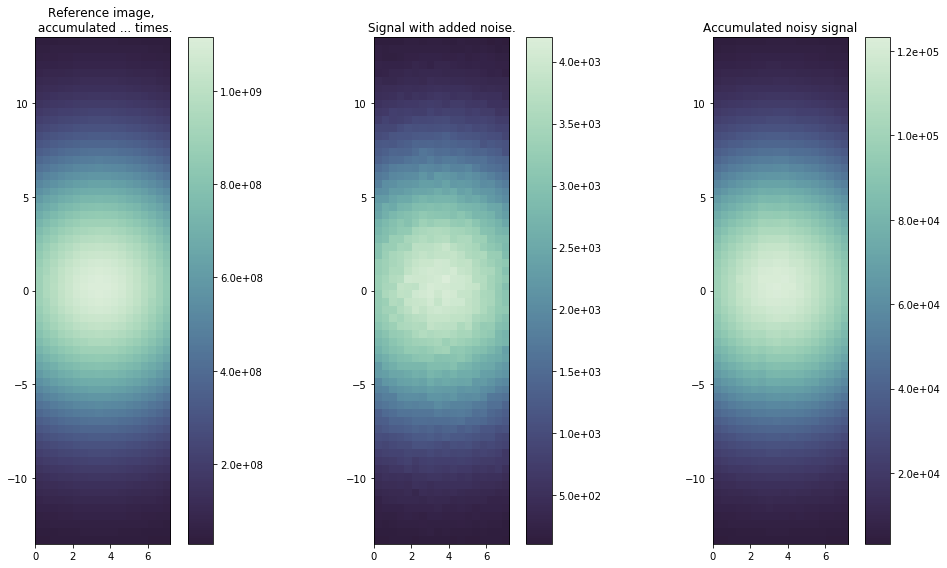

In [291]:
cmap2 = sns.cubehelix_palette(256, start=0.5, rot=-0.6, dark=0.15, light=0.9, reverse=True, as_cmap=True)
plot_det(cmap2, (15,8), base_noise_acc, exp_with_noise, exp_noise_acc)

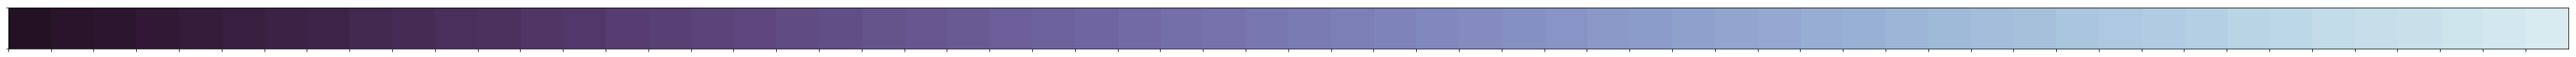

In [185]:
sns.palplot(sns.cubehelix_palette(60, start=0.5, rot=-0.35, dark=0.1, light=0.7, reverse=True))
